In [1]:
# standard imports
import numpy as npu
from tqdm import tqdm
import meshio
import matplotlib.pyplot as plt

In [2]:
# import geometry classes
from geometry.node import node
from geometry.cell import cell
from geometry.mesh import rot_sym_mesh
from problem.isentropic_navier_stokes import convection, diffusion, skalar_product,curl

# utility functions
from utilities.utilities import *
from utilities.pod import get_POD, get_activations

# Setting Custom Problem

In [3]:
# read su2 mesh file
meshio_mesh = meshio.read("./mesh_files/mesh_cylinder_quad.su2",file_format="su2")
# convert mesh into custom class exp_mesh
mesh = rot_sym_mesh(meshio_mesh)

    Surface tag  cylinder will be replaced by 1
    Surface tag  farfield will be replaced by 2


Initializing Mesh---------------------------------------------------------------
Mesh Initialization Successful!-------------------------------------------------


# Geometric Constants

In [4]:
# DEFINING CONSTANTS
n = mesh.n          # number of nodes
N = mesh.N          # number of cells
T = 440             # number of snapshots
alpha = 1           # inner product coefficient  # method for derivative computation
gamma = 1.4         # isentropic coefficient -> material property
max_POD = 40        # maximum number of POD modes
mach = 0.6          # mach number
sos = 340.29        # isentropic speed of sound
u_free = mach * sos # freestream velocity
Re = 100            # Reynolds number of freeflow
dt = 0.0001         # simulation time step
include_avg = False # include average flow in POD computation
nondim = True       # apply nondimensionalization to data
subsampling = 3     # subsampling for data

# Data Preparation

In [5]:
# reading file data
data_dir  = "./flow_data./lam_cyl_comp_air/mach 0.6/"
data_dict = read_csv_data(data_dir,delay=0,subsampling=subsampling,max_size=T)

# geometric information
x = data_dict["x"][:,0] - 0.5
y = data_dict["y"][:,0]

# fluid velocity and mach number
u = np.divide(data_dict['Momentum_x'], data_dict['Density'])
v = np.divide(data_dict['Momentum_y'], data_dict['Density'])
if nondim:
    u = u / (mach * sos)
    v = v / (mach * sos)
    u_free = 1
a = data_dict['Mach']

# construct state based data
q = np.vstack([u,v,a])
T = q.shape[1]
q_avg = np.mean(q,1)
q_fluc = q - np.repeat(np.expand_dims(q_avg,1),T,axis=1)

# data for pod decomposition
if include_avg:
    pod_data = q
else:
    pod_data = q_fluc

### set scalar weights for multiplicative computation
# volume participations
volume_weight = mesh.volume_weights
# additional weight for speed of sound
mach_weight = (2 * alpha / (gamma - 1))
# construction of weights
inner_weight = np.concatenate([np.ones(n),np.ones(n),mach_weight*np.ones(n)]) * volume_weight

100%|██████████| 440/440 [02:12<00:00,  3.32it/s]


# POD Decomposition

In [6]:
[pod_modes, S] = get_POD(pod_data,inner_weight,20)
coeffs = get_activations(pod_data,pod_modes,inner_weight,20)

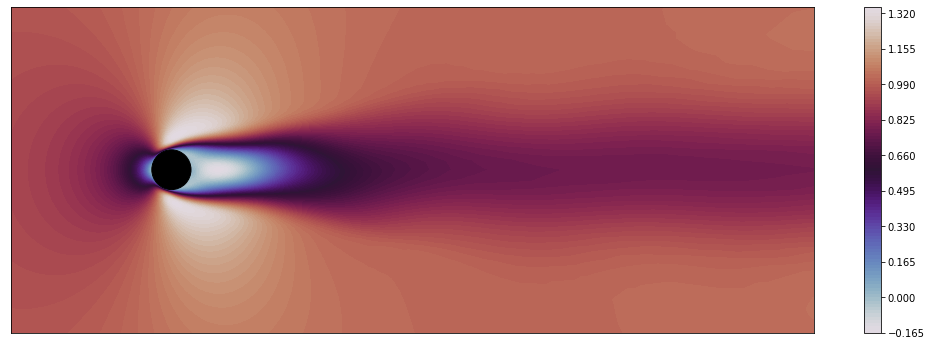

In [7]:
plot_cylinder_data(x,y,q_avg[:n],zoom=True,cmap='twilight')
#plt.savefig("mach_0.6_POD_q_avg.png")

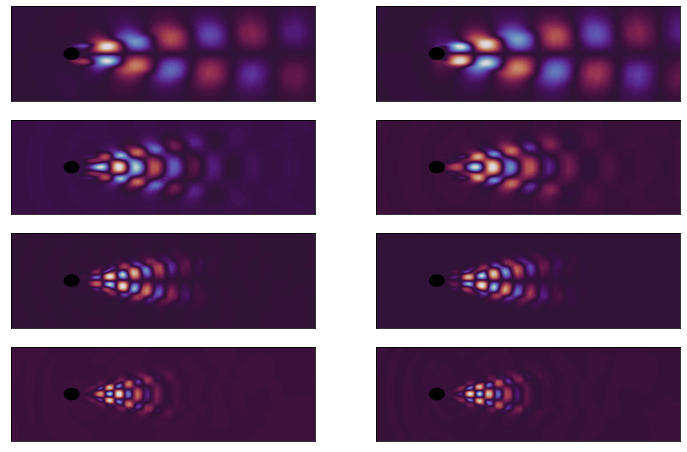

In [8]:
mode = 7
# momentum = np.sqrt(np.square(pod_modes[:n,mode]) + np.square(pod_modes[n:2*n,mode]))
# plot_cylinder_data(x,y,pod_modes[:n,mode],zoom=True,cmap='twilight')

fig, ax = plt.subplots(4,2,figsize=(12,8))

for i in range(8):
    plot_cylinder_data(x, y, pod_modes[:n,i], zoom=True, cmap='twilight', ax = ax[i//2][i%2],cbar=False)

# fig.colorbar(ax=ax)
# plt.savefig("mach_0.6_PODModes.png")

In [9]:
# energy reconstruction threshold
epsilon = 0.998
acc = 0
num = 0
while acc < epsilon:
    num+=1
    acc = sum(S[:num])/sum(S)    
print("Number of eigenvectors necessary for thresholded reconstruction: \t" + str(num))
if num % 2 == 1:
    num+=1

# manual value
num = 4

Number of eigenvectors necessary for thresholded reconstruction: 	6


In [10]:
def plot_activations(coeffs,num,dt):
    t = np.linspace(0,(coeffs.shape[1]-1)*dt,coeffs.shape[1])

    rows = int(num//2)
    fig, ax = plt.subplots(rows,1,figsize=(10,2*8))
    fig.tight_layout(pad=3.0)
    for i in range(rows):
        ax[i].plot(t,coeffs[2*i,:])
        ax[i].plot(t,coeffs[2*i + 1,:])
        ax[i].title.set_text("Eigenflow " + str(i) + " and " + str(i+1))

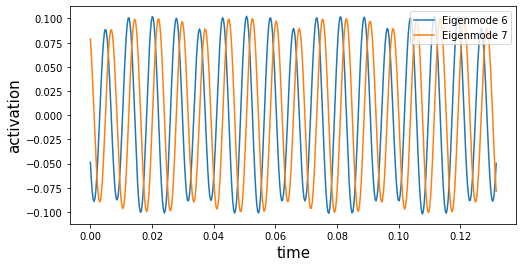

In [11]:
t = np.linspace(0,(coeffs.shape[1]-1)*dt*subsampling,coeffs.shape[1])

fig, ax = plt.subplots(1,1,figsize=(8,4))
ax.plot(t,coeffs[6,:],label="Eigenmode 6")
ax.plot(t,coeffs[7,:],label="Eigenmode 7")
ax.set_xlabel("time",size=15)
ax.set_ylabel("activation",size=15)
ax.legend(loc="upper right")
#plt.savefig("mach_0.01_pod_activ_eig_6_7.png")

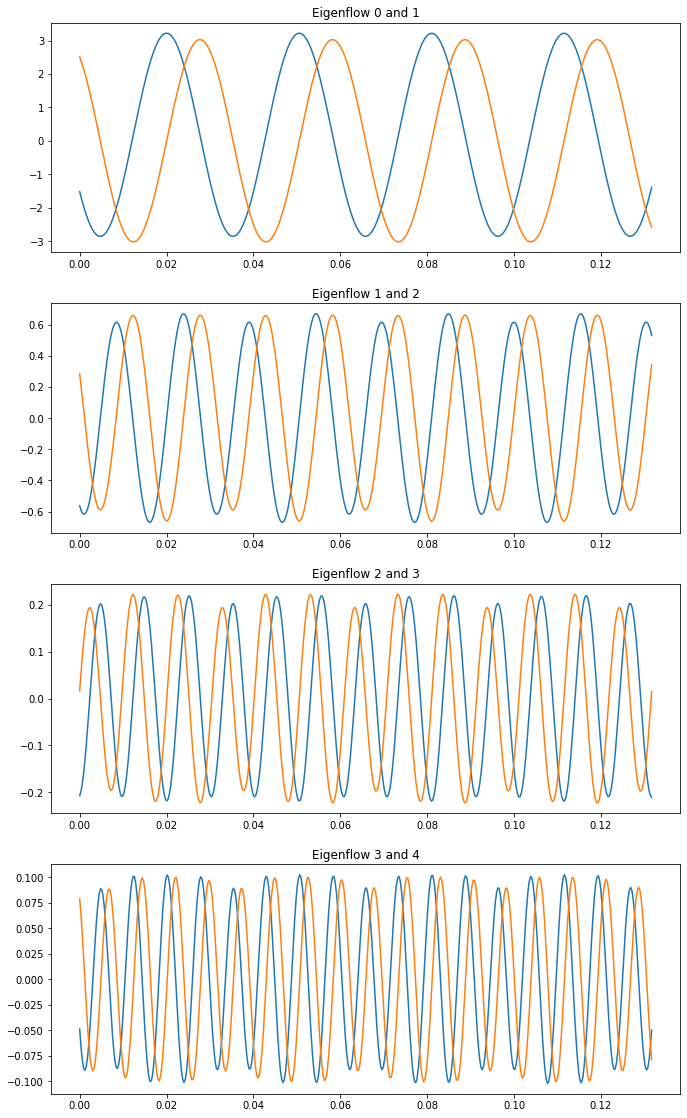

In [12]:
plot_activations(coeffs,8,dt=dt*subsampling)

# Reconstruction

In [13]:
# code for pod based reconstruction
rec_error = np.zeros(21)
for i in tqdm(range(0,21)):
    rec = np.zeros_like(q_fluc)
    # reconstruction
    for j in range(i):
        rec += np.outer(pod_modes[:,j],coeffs[j,:])

    # error calculation
    for j in range(rec.shape[1]):
        rec_error[i] += np.sum(np.square(rec[:,j] - q_fluc[:,j]))
    rec_error[i] /= (n * T) 

100%|██████████| 21/21 [00:31<00:00,  1.52s/it]


Text(0, 0.5, 'Reconstruction Error')

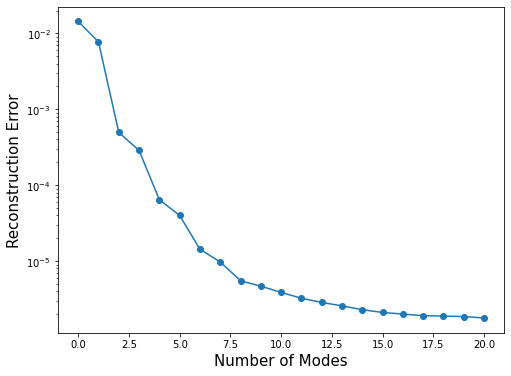

In [14]:
fig, ax = plt.subplots(1,1,figsize=(8,6))
ax.semilogy(rec_error,marker='o')
ax.set_xlabel("Number of Modes",size=15)
ax.set_ylabel("Reconstruction Error",size=15)
#plt.savefig("mach_0.01_rec_error.png")

In [15]:
rec = np.zeros_like(q_fluc)
for j in range(6):
    rec += np.outer(pod_modes[:,j],coeffs[j,:])

rec += np.repeat(np.expand_dims(q_avg,1),T,1)

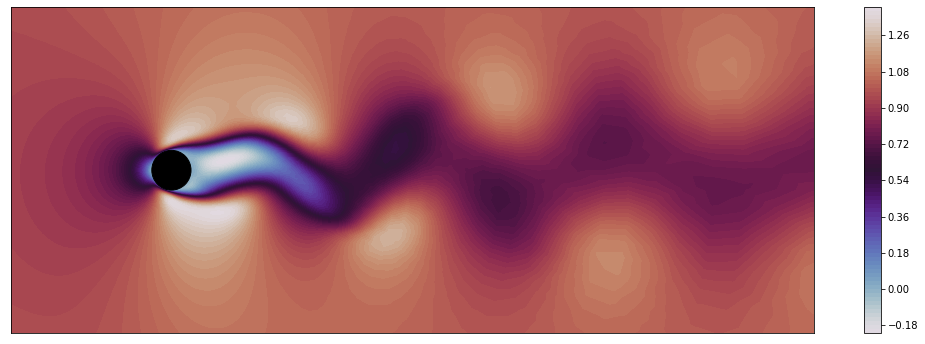

In [16]:
plot_cylinder_data(x,y,rec[:n,0],zoom=True,cmap='twilight')
#plt.savefig("mach_0.01_rec_6_modes_snap_0.png")

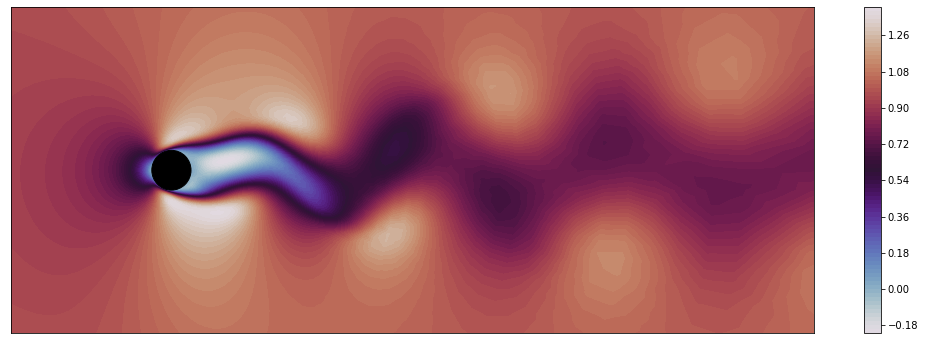

In [17]:
plot_cylinder_data(x,y,q[:n,0],zoom=True,cmap='twilight')
#plt.savefig("mach_0.01_gt_snap_0.png")

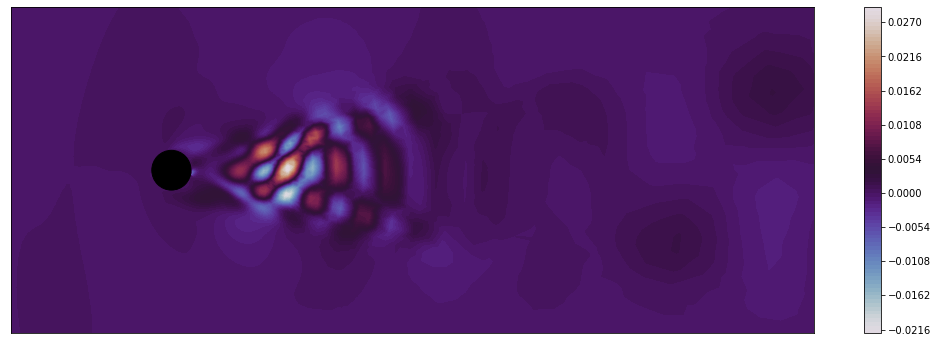

In [18]:
plot_cylinder_data(x,y,rec[:n,50]-q[:n,50],zoom=True,cmap='twilight')
#plt.savefig("mach_0.01_rec_6_modes_diff_snap_50.png")

# Control Data Input

In [19]:
control_dir  = "./flow_data/lam_cyl_comp_air/potVortex 0.6/"
control_dict = read_csv_data(control_dir,0,1,1)

u_con = np.divide(control_dict['Momentum_x'], control_dict['Density'])
v_con = np.divide(control_dict['Momentum_y'], control_dict['Density'])
a_con = control_dict['Mach']

# construct state based data
q_con = np.vstack([u_con,v_con,a_con]).squeeze()

100%|██████████| 1/1 [00:00<00:00,  3.36it/s]


# Control Function Method
Additional coefficients in Galerkin system

In [20]:
# Computation of Galerkin control terms
Lcon = diffusion(mesh,q_con)
Qcon = convection(mesh,q_con,q_con)
Qconavg_1 = convection(mesh,q_con,q_avg)
Qconavg_2 = convection(mesh,q_avg,q_con)

# initialize arrays
d1 = np.empty(num)
d2 = np.empty(num)
f = np.empty(num)
g = np.empty((num,num))
h = np.empty(num)

# compute temporary L and Q operators for projection
tmp_1 = np.empty((num,3*n))
tmp_2 = np.empty((num,3*n))
for i in tqdm(range(num)):
    tmp_1[i] = convection(mesh,q_con,pod_modes[:,i])
    tmp_2[i] = convection(mesh,pod_modes[:,i],q_con)

# compute finale coefficients
for k in range(num):
    d1[k] = skalar_product(Lcon,pod_modes[:,k],inner_weight)
    d2[k] = skalar_product(Qconavg_1 + Qconavg_2,pod_modes[:,k],inner_weight)
    f[k] = skalar_product(Qcon,pod_modes[:,k],inner_weight)
    h[k] = skalar_product(q_con,pod_modes[:,k],inner_weight)
    for i in range(num):
        g[k,i] = skalar_product(tmp_1[i] + tmp_2[i],pod_modes[:,k],inner_weight)

100%|██████████| 4/4 [00:01<00:00,  2.71it/s]


# Galerkin system

In [21]:
# Galerkin system coefficients
# Computation of Galerkin system parameters
Qavg = convection(mesh,q_avg,q_avg)
Lavg = diffusion(mesh,q_avg)

# initialize arrays for parameters
b1 = np.empty(num)
b2 = np.empty(num)
L1 = np.empty((num,num))
L2 = np.empty((num,num))
Q_ = [np.empty((num,num,)) for x in range(num)]

# compute L and Q operators for projection
Q_tmp1 = np.empty((num,3*n))
Q_tmp2 = np.empty((num,3*n))
Q_tmp3 = np.empty((num,num,3*n))
L_tmp = np.empty((num,3*n))

for i in tqdm(range(num)):
    Q_tmp1[i] = convection(mesh,q_avg,pod_modes[:,i])
    Q_tmp2[i] = convection(mesh,pod_modes[:,i],q_avg)
    L_tmp[i] = diffusion(mesh,pod_modes[:,i])
    for j in range(num):
        Q_tmp3[i,j] = convection(mesh,pod_modes[:,i],pod_modes[:,j])

# compute ODE coefficients
for k in tqdm(range(num)):
    b1[k] = skalar_product(Lavg,pod_modes[:,k],inner_weight)
    b2[k] = skalar_product(Qavg,pod_modes[:,k],inner_weight)
    for i in range(num):
        L1[k,i] = skalar_product(L_tmp[i],pod_modes[:,k],inner_weight)
        L2[k,i] = skalar_product(np.add(Q_tmp1[i],Q_tmp2[i]),pod_modes[:,k],inner_weight)
        for j in range(num):
            Q_[k][i,j] = skalar_product(Q_tmp3[i,j],pod_modes[:,k],inner_weight)

100%|██████████| 4/4 [00:00<00:00, 250.03it/s]


In [22]:
### bc penalty term
# velocity on boundary 
boundary_weight = np.zeros(3*n)

# compute ds
rad = mesh.points_pol[-200,0]
ds = 2 * np.pi * rad / 200

# set boundary weights for skalar product
boundary_weight[n-200:n] = ds
boundary_weight[2*n-200:2*n] = ds
boundary_weight[3*n-200:3*n] = ds * mach_weight

# state based freestream condition
q_inf = np.concatenate([np.repeat(u_free,n),np.zeros(n),np.repeat(0.6,n)])

# bc
G1 = np.empty((num,num))
G2 = np.empty(num)
for i in range(num):
    for j in range(i,num):
        G1[i,j] = skalar_product(pod_modes[:,i],pod_modes[:,j],boundary_weight)
        G1[j,i] = G1[i,j]
    G2[i] = skalar_product(pod_modes[:,i],q_inf,boundary_weight)

In [34]:
# initial conditions
a0 = coeffs[:num,20]

# sampling span for solver
t0 = 0
dt_gal = 0.01
tmax = 160
sampling_span = np.linspace(t0,tmax-dt_gal,num=int(tmax/dt_gal))
tau = 6.5 # experimentally tuned 
# static viscosity
nu = 1/100

# defining ode function for node based coefficients
def galerkin_system(t,a):
    # set global variables references
    global Q_, L1, L2, b1, b2, nu
    
    a_dot = np.empty_like(a)
    
    for k in range(a_dot.shape[0]):
        a_dot[k] = (nu * b1[k] + b2[k] + np.inner((nu*L1[k,:]+L2[k,:]),a) + np.matmul(np.matmul(np.expand_dims(a,1).T,Q_[k]),np.expand_dims(a,1))) #- (tau * (np.inner(G1[k,:],a) - G2[k]))
    return a_dot

In [35]:
from scipy.integrate import solve_ivp
sol = solve_ivp(galerkin_system,(t0,tmax),a0,method='LSODA',t_eval=sampling_span)
sol.message

<ipython-input-34-4d76d31c2652>:21: RuntimeWarning: overflow encountered in matmul
  a_dot[k] = (nu * b1[k] + b2[k] + np.inner((nu*L1[k,:]+L2[k,:]),a) + np.matmul(np.matmul(np.expand_dims(a,1).T,Q_[k]),np.expand_dims(a,1))) #- (tau * (np.inner(G1[k,:],a) - G2[k]))


'The solver successfully reached the end of the integration interval.'

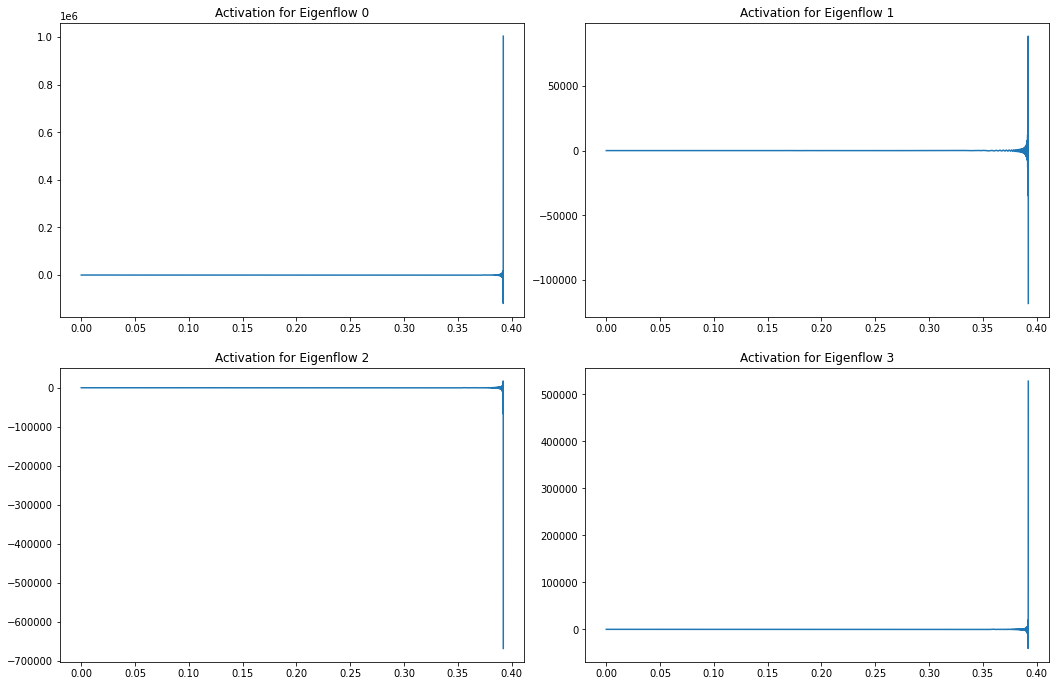

In [36]:
# Galerkin model based on discrete reconstruction
d = int(num/2)
fig,ax = plt.subplots(d,2,figsize=(15,10))
fig.tight_layout(pad=3.0)

t = sampling_span * 0.005

# add plots over full time domain
for i in range(num):
    if num <= 2:
        ax[int(i%2)].plot(t[:],sol.y[i,:len(t)])
        ax[int(i%2)].title.set_text("Activation for Eigenflow " + str(i))
    else:
        ax[int(i/2)][int(i%2)].plot(t[:],sol.y[i,:len(t)])
        ax[int(i/2)][int(i%2)].title.set_text("Activation for Eigenflow " + str(i))

    plt.savefig("mach_0.6_unstabilized.png")

In [26]:
# reconstruct flows
rec_len = 100
rec = np.repeat(np.expand_dims(q_avg,1),rec_len,1)
for i in range(num):
    rec += np.outer(pod_modes[:,i],sol.y[i,-100:])
